In this project, I examine a dataset which contains transactions for all stores that have a class E liquor license in the state of Iowa and analyze the dataset from the perspective of a data scientist in residence at the Iowa State tax board. The Iowa State legislature is considering changes in the liquor tax rates and wants a report of current liquor sales by county and projections for the rest of the year.

The goals of this project are to: 
- Calculate the yearly liquor sales for each score using the provided data. You can add up the transactions for each year, and store sales in 2015 specifically will be used later as your target variable
- Use the data from 2015 to make a linear model using as many variables as you find useful to predict the yearly sales of each store. You must use the sales from Jan to March per store as one of your variables
- Use your model for 2015 to estimate total sales for each store in 2016, extrapolating from the sales so far for Jan-March of 2016
- Report your findings, including any projected increase or decrease in total sales (over the entire state) for the tax committee of the Iowa legislature
- Use cross-validation to check how your model predicts to held out data compared to the model metrics on the full dataset
- Fit your model(s) using one or both of the regularization tactics covered. Explain whether the regularized or the non-regularized model performed better and what the selected regression(s) are doing

I start with some exploratory data analysis.

*Note: The dataset containing all transactions is very large, so I decided to run my analysis on a random sample of 10% of the transactions.

#### Cleaning the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

# Stop showing SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
## Load the data into a DataFrame
# pd.read_csv()
df = pd.read_csv('Iowa_Liquor_sales_sample_10pct.csv')

## Transform the dates if needed, e.g.
df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y")
df.head()

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,2015-11-04,3717,SUMNER,50674,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,$4.50,$6.75,12,$81.00,9.0,2.38
1,2016-03-02,2614,DAVENPORT,52807,82.0,Scott,1011100.0,BLENDED WHISKIES,395,27605,Tin Cup,750,$13.75,$20.63,2,$41.26,1.5,0.40
2,2016-02-11,2106,CEDAR FALLS,50613,7.0,Black Hawk,1011200.0,STRAIGHT BOURBON WHISKIES,65,19067,Jim Beam,1000,$12.59,$18.89,24,$453.36,24.0,6.34
3,2016-02-03,2501,AMES,50010,85.0,Story,1071100.0,AMERICAN COCKTAILS,395,59154,1800 Ultimate Margarita,1750,$9.50,$14.25,6,$85.50,10.5,2.77
4,2015-08-18,3654,BELMOND,50421,99.0,Wright,1031080.0,VODKA 80 PROOF,297,35918,Five O'clock Vodka,1750,$7.20,$10.80,12,$129.60,21.0,5.55


I check the size of the dataframe:

In [4]:
print(df.shape)

(270955, 18)


I also check for null values:

In [5]:
print(df.isnull().sum())

Date                        0
Store Number                0
City                        0
Zip Code                    0
County Number            1077
County                   1077
Category                   68
Category Name             632
Vendor Number               0
Item Number                 0
Item Description            0
Bottle Volume (ml)          0
State Bottle Cost           0
State Bottle Retail         0
Bottles Sold                0
Sale (Dollars)              0
Volume Sold (Liters)        0
Volume Sold (Gallons)       0
dtype: int64


#### Fill in null County names & numbers

There are 1077 missing County Numbers and County Names. To fix this, I create a deduplicated dataframe of every entry where county name is null, and a deduplicated dataframe of every entry where country name is not null.

Then, for each city i in the null county dataframe, I find if the city i exists in the not null county dataframe, and if there's a match, I take the county associated with city i in the not null dataframe and replace the null county name with this value.

In [6]:
# Creates df of city, county number & county where county is null, drops duplicates
df_n = df[['City', 'County Number', 'County']][df.County.isnull()].drop_duplicates()

# Creates df where county is not null, drops duplicates
df_nn = df[['City', 'County Number', 'County']][df.County.notnull()].drop_duplicates()

for i in df_n.City: # for each city in the null county df
    if df_nn.City.str.contains(i).any(): # if the city exists in the not null df
        df.County[(df.County.isnull()) & (df.City == i)] = df_nn.County[df_nn.City == i].iloc[0]
        # put the county associated with the city into the original df (where the county was null)
        
        #same for county number
        df['County Number'][(df['County Number'].isnull()) &
                            (df.City == i)] = df_nn['County Number'][df_nn.City == i].iloc[0]

del df_n
del df_nn

# Find all Cities that still don't have an associated County name and number
df.City[df['County Number'].isnull()].unique() # print null county numbers

array(['TABOR', 'SEYMOUR', 'RUNNELLS'], dtype=object)

There are still 4 cities where the county number is null. I imagine this is because these cities existed in the null dataframe, but did not appear in the not_null dataframe. Since there are only 4 entries, I just went on Wikipedia and found which counties these cities are in.

To fill in the county number, after I found the county name on Wikipedia, I filtered the df to find the corresponding county number for each missing county name.

In [7]:
# Fill in null Counties

# Went on Wikipedia to find which County Seymour is in
# Used df[df.County == 'Wayne'] to find the corresponding Number

df.County[df.City == 'SEYMOUR'] = 'Wayne'
df['County Number'][df.City == 'SEYMOUR'] = '93.0'
df.County[df.City == 'RUNNELLS'] = 'Polk'
df['County Number'][df.City == 'RUNNELLS'] = '77.0'

df.County[df.City == 'TABOR'] = 'Fremont'
df['County Number'][df.City == 'TABOR'] = '36'

df[df['County Number'].isnull()]

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)


No more missing counties!

#### Fill in null categories & category names where possible

Recall that where were also 68 missing categories and 632 missing category numbers. I use the same process that I used to fill in missing counties to try to fill in missing categories:

In [8]:
# follow same procedure to fill in null categories
df_ncat = df[['Category', 'Category Name', 'Item Description']][df.Category.isnull()].drop_duplicates()
df_nncat = df[['Category', 'Category Name', 'Item Description']][df.Category.notnull()].drop_duplicates()

for i in df_ncat['Item Description']: # for all items in df with null categories
    if df_nncat['Item Description'].str.contains(i).any(): # if there is a matching item in not nut df
        df.Category[(df.Category.isnull()) &
                    (df['Item Description'] == i)] = df_nncat.Category[df_nncat['Item Description'] == i].iloc[0]
        
        df['Category Name'][(df['Category Name'].isnull()) &
                            (df['Item Description'] == i)] = df_nncat['Category Name'][df_nncat['Item Description'] ==
                                                                                       i].iloc[0]

df.isnull().sum()

Date                       0
Store Number               0
City                       0
Zip Code                   0
County Number              0
County                     0
Category                  39
Category Name            603
Vendor Number              0
Item Number                0
Item Description           0
Bottle Volume (ml)         0
State Bottle Cost          0
State Bottle Retail        0
Bottles Sold               0
Sale (Dollars)             0
Volume Sold (Liters)       0
Volume Sold (Gallons)      0
dtype: int64

I was able to fill in a few dozen categories and category names, but these are much more difficult to fill than missing counties. I'm ok with a few missing categories.

Next, I clean up the dataset a little more by making the numbers a little easier to work with:

1. Convert currency columns to floats
2. Pull months & years from Date column
3. Print cheapest drinks

In [9]:
# Convert string currencies to floats
df['State Bottle Cost'] = df['State Bottle Cost'].replace('[\$,]','',regex=True).astype(float)
df['State Bottle Retail'] = df['State Bottle Retail'].replace('[\$,]','',regex=True).astype(float)
df['Sale (Dollars)'] = df['Sale (Dollars)'].replace('[\$,]','',regex=True).astype(float)
df['Profit Margin'] = (df['State Bottle Retail'] - df['State Bottle Cost']) / df['State Bottle Retail']
df['Profit'] = (df['State Bottle Retail'] - df['State Bottle Cost']) * df['Bottles Sold']
df['Price per ml'] = df['State Bottle Retail'] / df['Bottle Volume (ml)']

# Get month & yeear
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df.head()

# Cheapest drinks
print df['Item Description'][df['State Bottle Retail'] == min(df['State Bottle Retail'])].unique()
print ''
# Volume & Price of cheapest drinks
print df[['Bottle Volume (ml)', 'State Bottle Retail']][df['State Bottle Retail'] == min(df['State Bottle Retail'])].drop_duplicates()
print ''
# Drinks that aren't sold for profit
print df['Item Description'][df['Profit Margin'] == min(df['Profit Margin'])].unique()

['Fireball Cinnamon' 'Fireball Cinnamon Whisky' '99 Bananas'
 'Platinum 7x Vodka' 'Barton Gin' 'Canadian LTD' 'Hartley Brandy'
 'Barton Light Rum' 'Canadian Ltd']

      Bottle Volume (ml)  State Bottle Retail
1270                 100                 1.34

['Bonnie Rose Orange Peel Mini' 'Bonnie Rose Spiced Apple Mini']


That's pretty cool. The drinks that have the lowest retail price per bottle are Fireball, 99 Bananas, Platinum Vodka, Barton Gin, Canadian LTD, hartley Brandy, and Barton Light Rum.

The volume and price of those cheapest drinks are small 100ml (2 or so shots worth) bottles and they sell for $1.34. Interesting

I also thought it was cool to see the drinks that aren't sold at a profit. The Bonnie Rose brand Orange Peel Mini and Spiced Apple Mini have a 0% profit margin.

#### Explore the data

##### Get quarterly, annual & total sales by store

Next, I calculate the yearly liquor sales for each score using the provided data. As per the goals I stated at the beginning, "You can add up the transactions for each year, and store sales in 2015 specifically will be used later as your target variable."

I start by creating lists so that I can append sales data for each quarter to each list.

In [10]:
store_list = []
c = []
a = []
county = []
city = []
tot_sales = []
sales_15 = []
q1_15 = []
q2_15 = []
q3_15 = []
q4_15 = []
q1_16 = []
for i in df['Store Number'].unique():
    store_list.append(i)
    
    c.append(df.County[df['Store Number'] == i].unique())
    
    a.append(df.City[df['Store Number'] == i].unique())

    tot_sales.append(sum(df['Sale (Dollars)'][df['Store Number'] == i]))
    
    sales_15.append(sum(df['Sale (Dollars)'][(df['Store Number'] == i) & 
                                             (df.year == 2015)]))
    
    q1_15.append(sum(df['Sale (Dollars)'][(df['Store Number'] == i) &
                                      (df.year == 2015) & (df.month <= 3)]))
    
    q2_15.append(sum(df['Sale (Dollars)'][(df['Store Number'] == i) &
                                      (df.year == 2015) & (df.month > 3) & (df.month <= 6)]))
    
    q3_15.append(sum(df['Sale (Dollars)'][(df['Store Number'] == i) &
                                      (df.year == 2015) & (df.month > 6) & (df.month <= 9)]))
    
    q4_15.append(sum(df['Sale (Dollars)'][(df['Store Number'] == i) &
                                      (df.year == 2015) & (df.month > 9) & (df.month <= 12)]))
    
    q1_16.append(sum(df['Sale (Dollars)'][(df['Store Number'] == i) &
                                      (df.year == 2016) & (df.month <= 3)]))

countylist = []
for i in range(len(c)):
    countylist.append(c[i][0])
    
citylist = []
for i in range(len(a)):
    citylist.append(a[i][0])
    

df_sales = pd.DataFrame({'Store Number': store_list,
                         'City': citylist,
                         'County': countylist,
                         'q1_15': q1_15,
                         'q2_15': q2_15,
                         'q3_15': q3_15,
                         'q4_15': q4_15,
                         'q1_16': q1_16,
                         '2015 Sales': sales_15,
                         'Total Sales': tot_sales
                          })

df_sales = df_sales[['Store Number', 'City', 'County', 'q1_15', 'q2_15', 'q3_15', 'q4_15', 'q1_16', '2015 Sales', 'Total Sales']]
print df_sales.head()

   Store Number         City      County     q1_15     q2_15     q3_15  \
0          3717       SUMNER      Bremer   1583.13   2168.16   2456.26   
1          2614    DAVENPORT       Scott  32260.12  43463.45  27085.47   
2          2106  CEDAR FALLS  Black Hawk  39287.29  31173.46  38324.77   
3          2501         AMES       Story  31412.95  34085.38  30449.92   
4          3654      BELMOND      Wright   2312.42   3025.24   2016.90   

      q4_15     q1_16  2015 Sales  Total Sales  
0   2815.31   2510.46     9022.86     11533.32  
1  39866.25  39097.17   142675.29    181772.46  
2  37540.70  30523.75   146326.22    176849.97  
3  48885.41  29980.54   144833.66    174814.20  
4   2124.74   2394.38     9479.30     11873.68  


Ok, so now I have a new dataframe with quarterly sales for each store. Let's take a look at the best-perfoming stores:

In [11]:
df_sales[df_sales['Total Sales'] > 250000]

,Store Number,City,County,q1_15,q2_15,q3_15,q4_15,q1_16,2015 Sales,Total Sales
14,2670,CORALVILLE,Johnson,40125.22,70502.77,49655.76,67158.96,54701.99,227442.71,282144.70
36,2633,DES MOINES,Polk,207012.08,277634.39,212606.59,303530.24,219551.79,1000783.30,1220335.09
85,2512,IOWA CITY,Johnson,82117.82,113684.82,95105.01,128839.18,112518.79,419746.83,532265.62
97,4829,DES MOINES,Polk,203842.07,232202.13,206184.58,236583.92,210340.17,878812.70,1089152.87
221,3773,CEDAR RAPIDS,Linn,48574.94,57271.13,57595.57,69018.77,66202.79,232460.41,298663.20
335,3385,CEDAR RAPIDS,Linn,105921.75,106732.76,84844.26,144484.78,64605.54,441983.55,506589.09
339,3952,BETTENDORF,Scott,85840.78,81891.03,60512.49,105067.68,59139.45,333311.98,392451.43
365,3420,WINDSOR HEIGHTS,Polk,85542.78,122752.14,37903.62,105822.12,50555.40,352020.66,402576.06
371,3447,SIOUX CITY,Woodbury,54233.74,48084.12,27080.70,58251.48,75557.88,187650.04,263207.92
630,3814,WEST DES MOINES,Dallas,56443.62,60766.12,48415.20,81792.48,63118.98,247417.42,310536.40


By far the stores with the most sales are in Des Moines and Cedar Rapids, which makes sense as they are by far the cities with the highest populations. There are also some other cities with some decent sales figures. Let's try to visualize this.

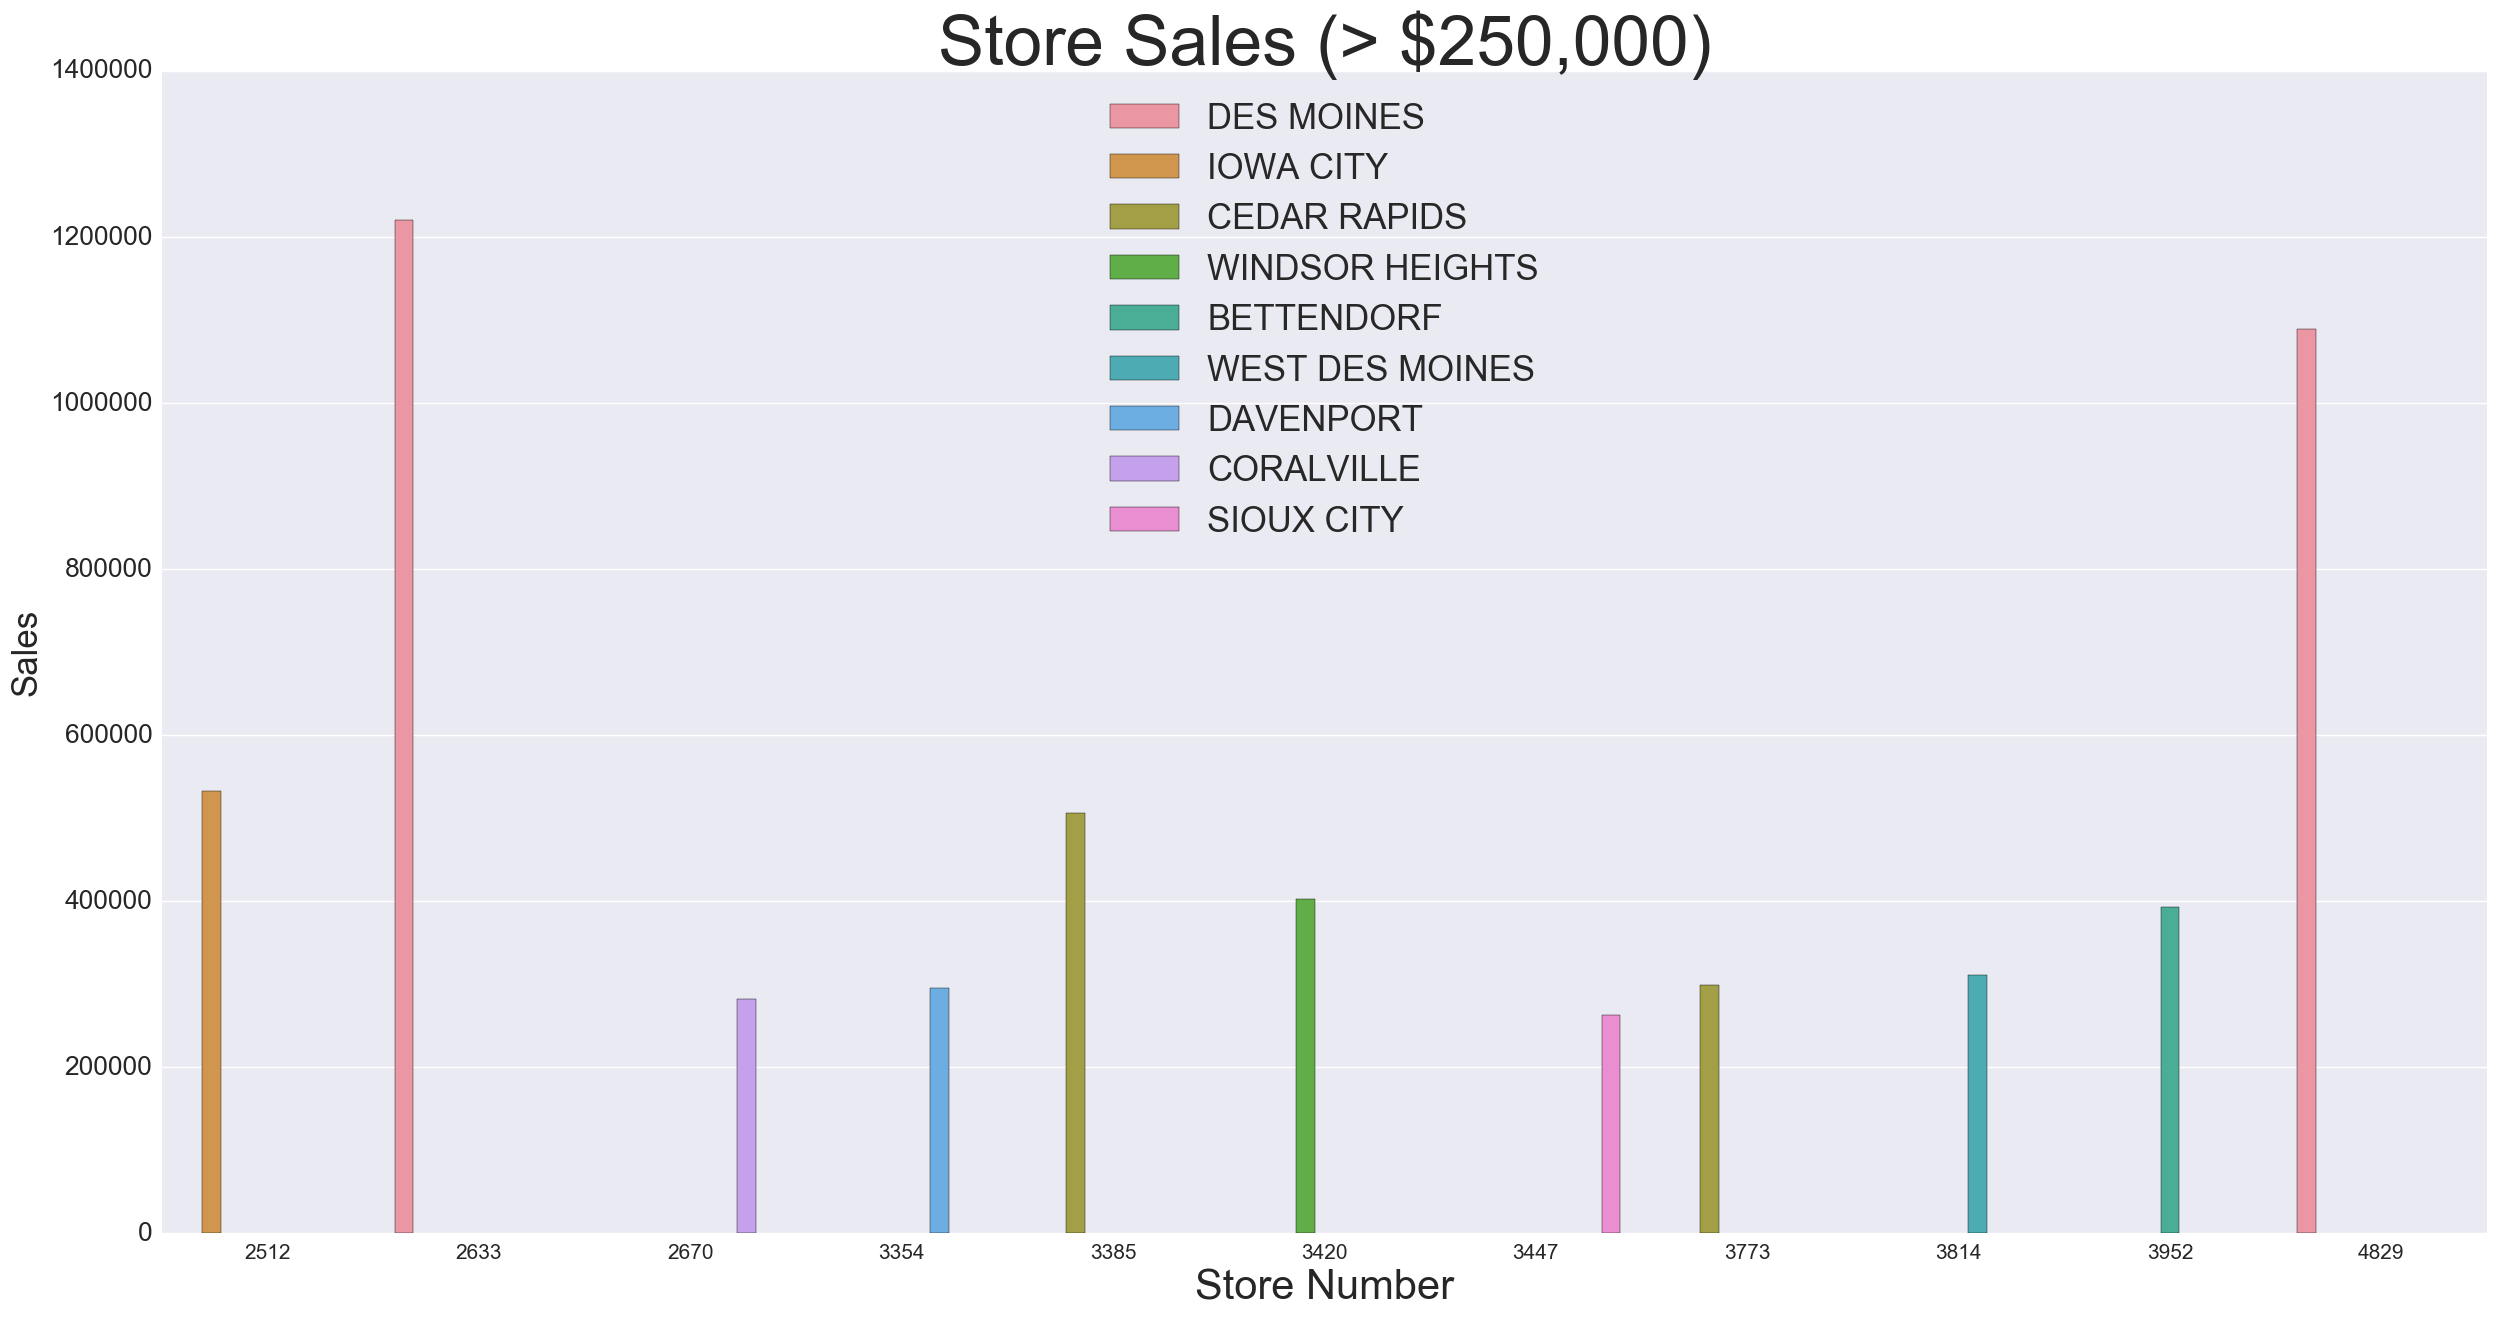

In [12]:
storesales = df_sales[df_sales['Total Sales'] > 250000]
storesales1 = storesales.sort_values('Total Sales', ascending=False)
plt.figure(figsize=(30,15))

sns.barplot(x=storesales1['Store Number'], 
            y=storesales1['Total Sales'],
            hue=storesales1.City)
plt.legend(loc=9, prop={'size':25})
plt.xticks(size=15)
plt.yticks(size=19)
plt.xlabel('Store Number', size=30)
plt.ylabel('Sales', size=25)
plt.title('Store Sales (> $250,000)', size=50)
plt.savefig('images/StoreSales.png')

In [11]:
storesales1

,Store Number,City,County,q1_15,q2_15,q3_15,q4_15,q1_16,2015 Sales,Total Sales
36,2633,DES MOINES,Polk,207012.08,277634.39,212606.59,303530.24,219551.79,1000783.30,1220335.09
97,4829,DES MOINES,Polk,203842.07,232202.13,206184.58,236583.92,210340.17,878812.70,1089152.87
85,2512,IOWA CITY,Johnson,82117.82,113684.82,95105.01,128839.18,112518.79,419746.83,532265.62
335,3385,CEDAR RAPIDS,Linn,105921.75,106732.76,84844.26,144484.78,64605.54,441983.55,506589.09
365,3420,WINDSOR HEIGHTS,Polk,85542.78,122752.14,37903.62,105822.12,50555.40,352020.66,402576.06
339,3952,BETTENDORF,Scott,85840.78,81891.03,60512.49,105067.68,59139.45,333311.98,392451.43
630,3814,WEST DES MOINES,Dallas,56443.62,60766.12,48415.20,81792.48,63118.98,247417.42,310536.40
221,3773,CEDAR RAPIDS,Linn,48574.94,57271.13,57595.57,69018.77,66202.79,232460.41,298663.20
744,3354,DAVENPORT,Scott,29695.26,50508.24,54116.40,106046.04,55227.36,240365.94,295593.30
14,2670,CORALVILLE,Johnson,40125.22,70502.77,49655.76,67158.96,54701.99,227442.71,282144.70


The 2 highest-sale stores are in Des Moines, Polk County, which makes sense because Des Moines has the highest population in Iowa.

#### Get county data

Next, I decided to get population information from each county just to get a better sense of the population spread in Iowa. I got the data frome here: http://www.iowa-demographics.com/counties_by_population.

I had to do a little cleaning to get the county columns to line up so I could append population, but overall it was a pretty straightforward process.

In [13]:
df2 = pd.read_csv('Untitled spreadsheet - Sheet1.csv', names=['County', 'Population'])

# Get rid of ' County' so the string matches the county data from df
df2.County = df2.County.map(lambda x: x.replace(' County', ''))

# Turn population column into float
df2.Population = df2.Population.replace('[,]','',regex=True).astype(int)

# Sort counties by name so County populations are appended to the correct County
df2 = df2.sort_values('County')
df2.head()
pop = df2.Population.tolist()


counties = df.County.unique().tolist()

# Get sales by county
county_sales = [(sum(df['Sale (Dollars)'][df.County == i])) for i in df.County.unique()]
df_county_sales = pd.DataFrame({'county': counties, 
                                'county_sales': county_sales})

df_county_sales = df_county_sales.sort_values('county')
df_county_sales['Population'] = pop
df_county_sales.head(1)

df_county_sales = df_county_sales.sort_values('county_sales', ascending=False)

Below, I visualize what liquor sales look like by county:

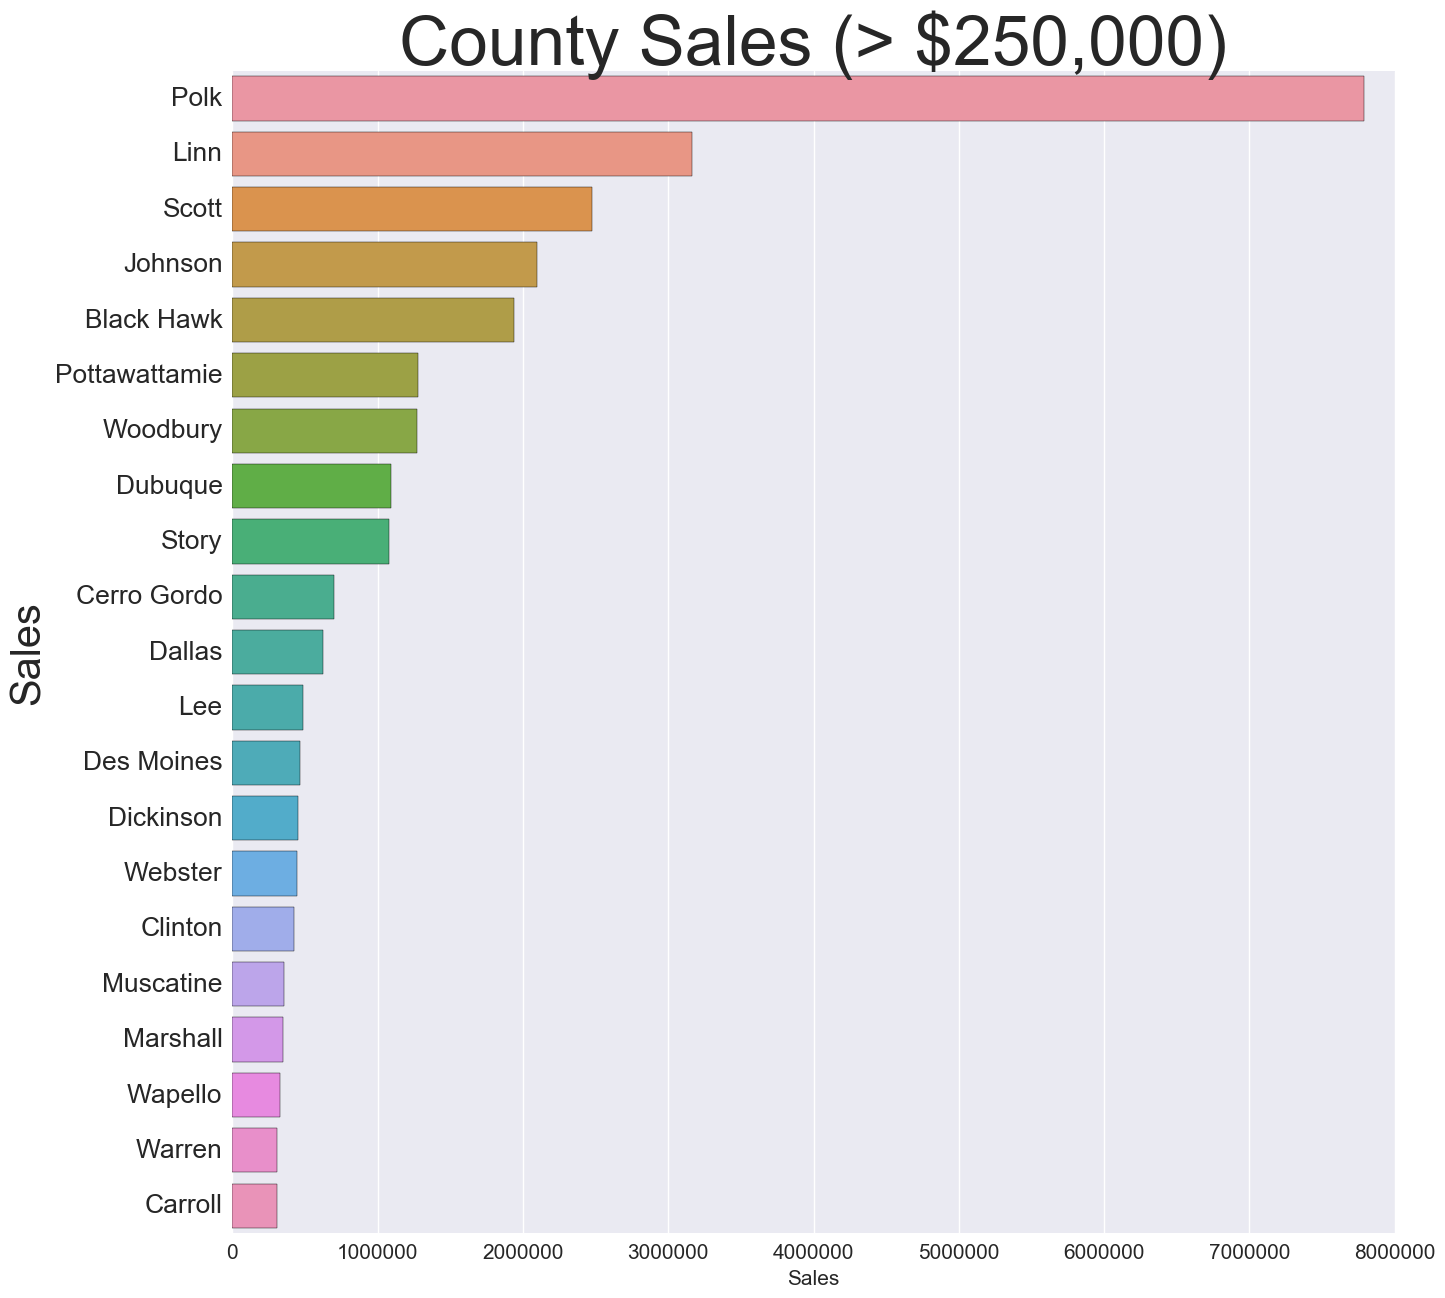

In [14]:
Sales250k = df_county_sales[df_county_sales.county_sales > 250000]
plt.figure(figsize=(15,15))
sns.barplot(x=Sales250k.county_sales, 
            y=Sales250k.county)
plt.xticks(size=15)
plt.yticks(size=19)
plt.xlabel('Sales', size=15)
plt.ylabel('Sales', size=30)
plt.title('County Sales (> $250,000)', size=50)
#plt.show()
plt.savefig('images/CountySales.png')

As we had seen before Polk County (home to Des Moines) and Linn County (home to Cedar Rapids) have the highest sales. Let's now compare this visualization with county population:

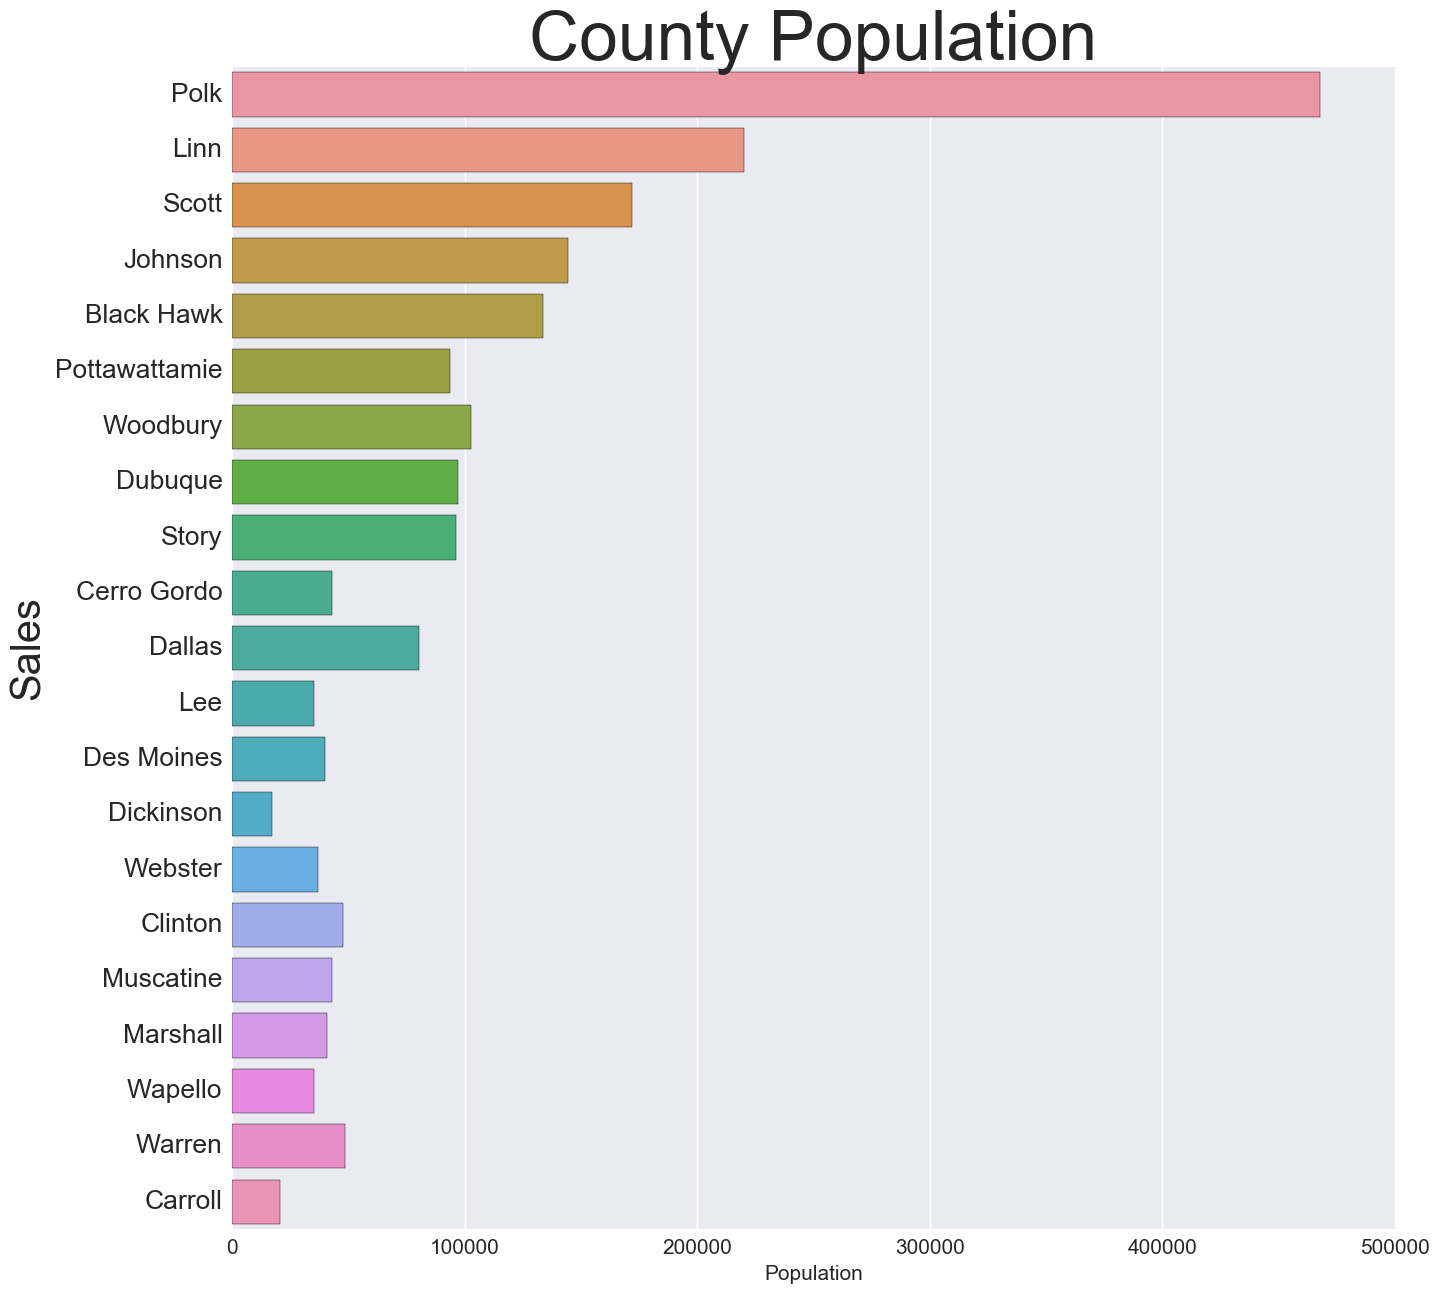

In [15]:
plt.figure(figsize=(15,15))
sns.barplot(x=Sales250k.Population, 
            y=Sales250k.county)
plt.xticks(size=15)
plt.yticks(size=19)
plt.xlabel('Sales', size=15)
plt.ylabel('Sales', size=30)
plt.xlabel('Population')
plt.title('County Population', size=50)
plt.savefig('images/CountyPop.png')

I sorted the plot so that the county populations are in line with the sales figures, which is why they're not exactly in order of highest to lowest population, they're in order of highest to lowest sales. But this is pretty much exactly in line with sales data with a few changes, e.g. there are more sales in Pottawattamie than in Woodbury even though Woodbury has a higher population.

### Get City Data

Next, I thought I'd get population data from cities in Iowa. I took the data from this website: http://www.iowa-demographics.com/cities_by_population.

This was a bit more complicated than getting the county population data because there were some cities that didn't overlap with my liquor sales dataset. I figured I'd only take cities that are in the liquor sales data and drop missing ones. Thankfully every city that appeared in the liquor dataset also appeared in the population dataset.

In [16]:
df3 = pd.read_csv('iowacitypop - Sheet1.csv', names=['City', 'Population'])
df3.City = df3.City.str.upper()
df3.Population = df3.Population.replace('[,]','',regex=True).astype(int)
popcity = df3.City.unique().tolist()

cities = df.City.unique().tolist()
sales_by_city = [(sum(df['Sale (Dollars)'][df.City == i])) for i in df.City.unique()]
df_city_sales = pd.DataFrame({'City': cities,
                          'Sales by City': sales_by_city
                          })

df_city_sales = df_city_sales.sort_values('City')

overlap = list(set(popcity) & set(cities))
df3 = df3[df3.City.isin(overlap)]
df_city_sales = df_city_sales[df_city_sales.City.isin(overlap)]

df3 = df3.sort_values('City')
pop = df3.Population.tolist()

df_city_sales['Population'] = pop

df_city_sales = df_city_sales.sort_values('Sales by City', ascending=False)

In [17]:
len(df_city_sales)

311

Wow. Liquor sales data from 311 cities. Next, I make similar visualizations that I made with the county data.

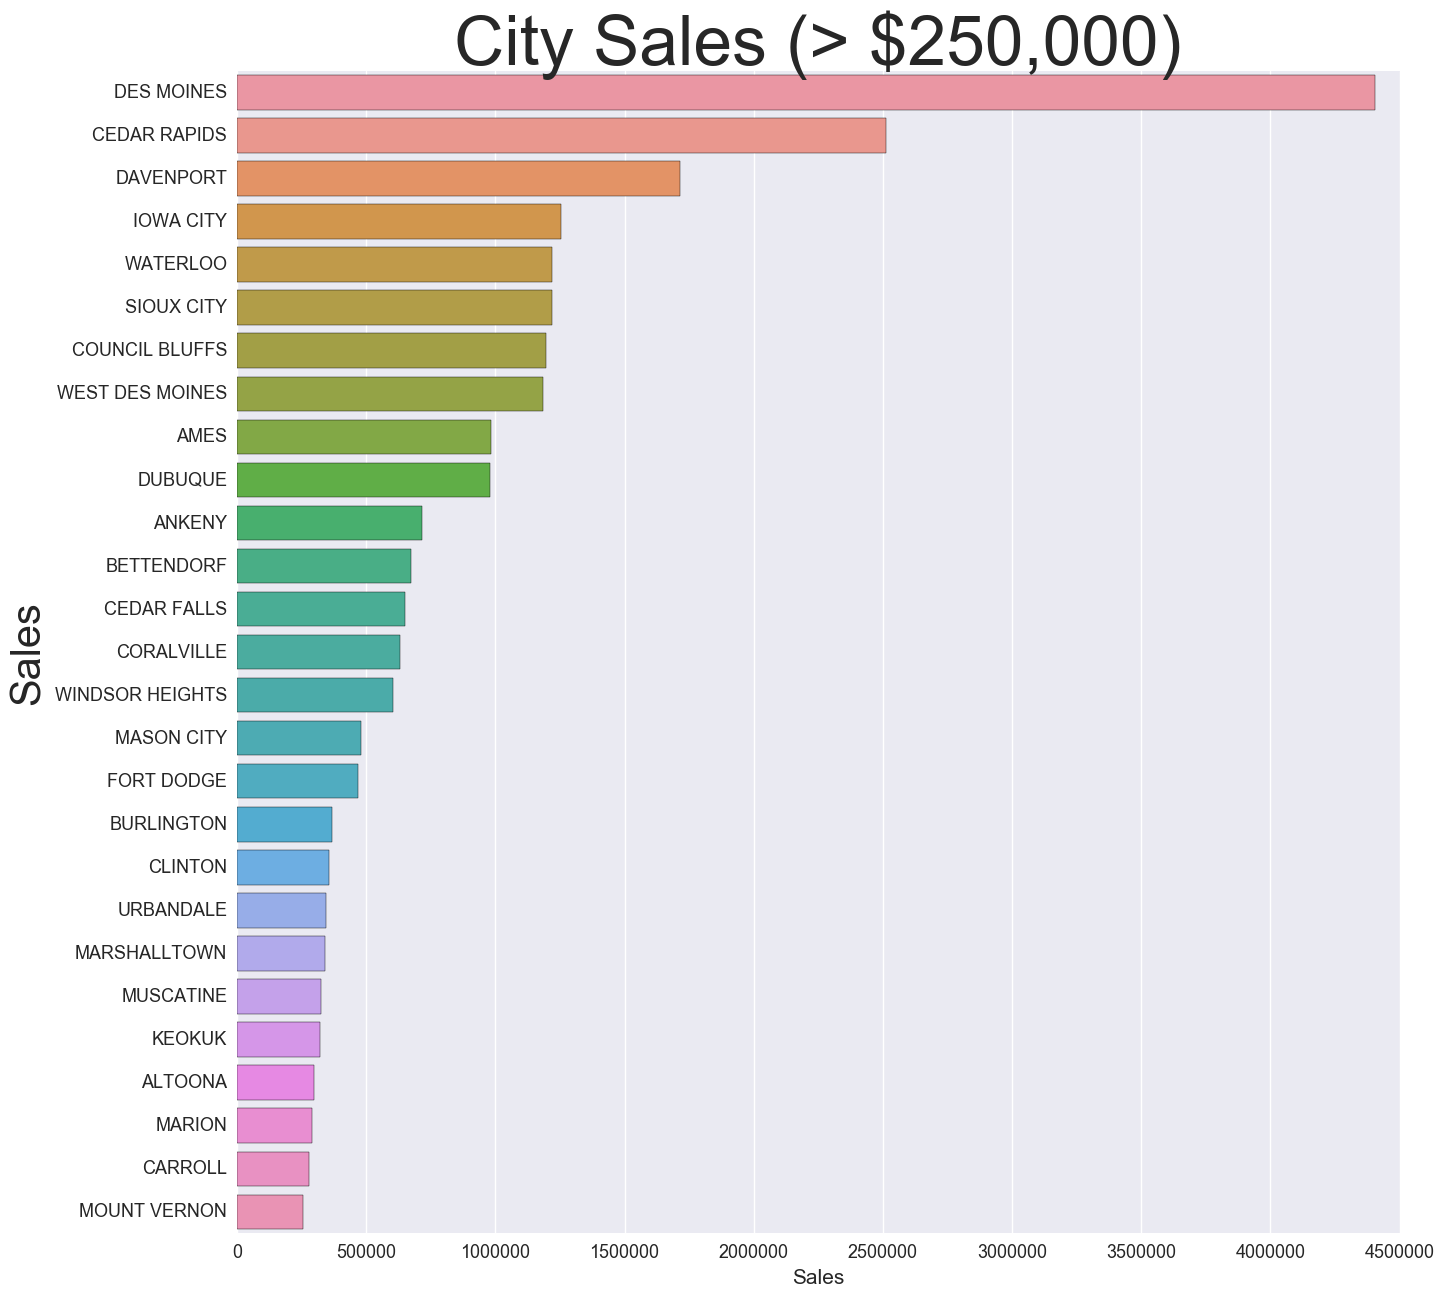

In [18]:
df_city_sales = df_city_sales.sort_values('Sales by City', ascending=False)
CitySales250k = df_city_sales[df_city_sales['Sales by City'] > 250000]

plt.figure(figsize=(15,15))
sns.barplot(x=CitySales250k['Sales by City'], 
            y=CitySales250k.City)
plt.xticks(size=13)
plt.yticks(size=13)
plt.xlabel('Sales', size=15)
plt.ylabel('Sales', size=30)
plt.title('City Sales (> $250,000)', size=50)
plt.savefig('images/CitySales.png')

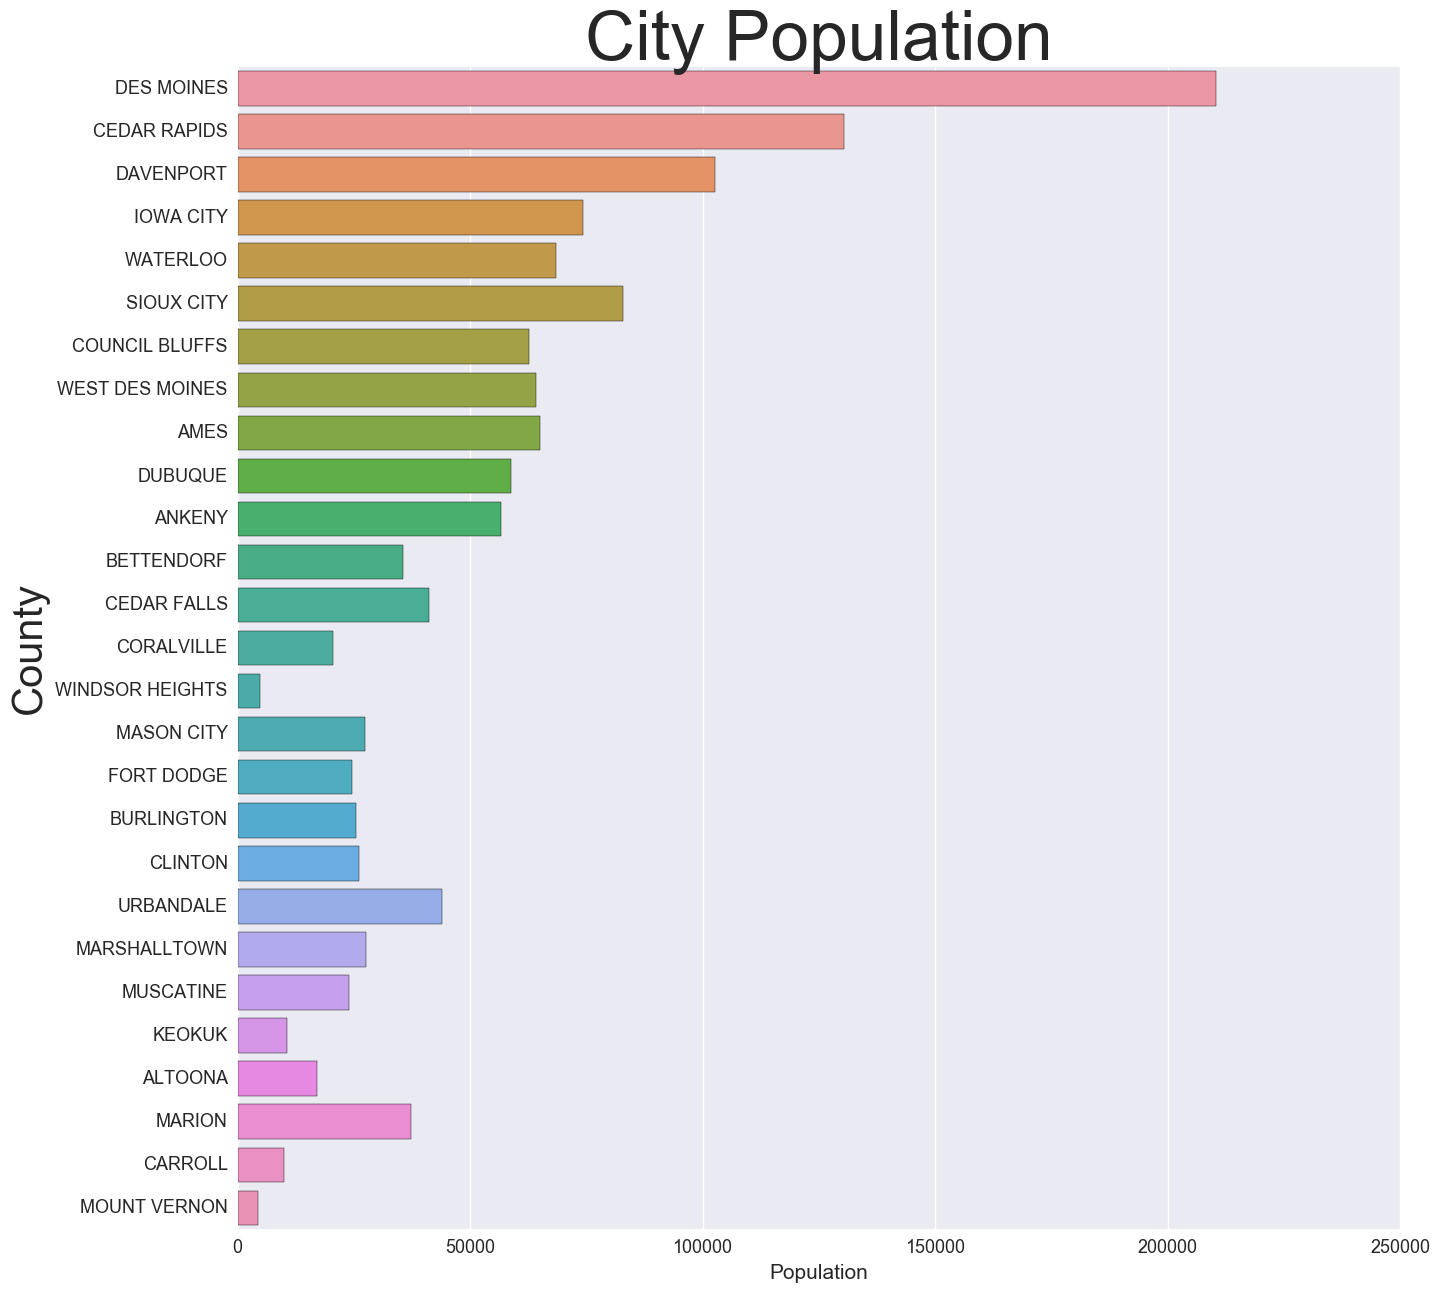

In [19]:
plt.figure(figsize=(15,15))
sns.barplot(x=CitySales250k.Population, 
            y=CitySales250k.City)
plt.xticks(size=13)
plt.yticks(size=13)
plt.xlabel('Population', size=15)
plt.ylabel('County', size=30)
plt.title('City Population', size=50)
plt.savefig('images/CityPop.png')

Again, we see a similar pattern. High sales in high population cities. Some weird outliers like Windsor Heights, but overall, is pretty much what I expected to see. I looked on Google Maps and Windsor Heights is literally right outsides of Des Moines, so I was wondering if it's cheaper to buy liquor in Windsor Heights (which may explain its high sales to population ratio) than it is to buy liquor in Des Moines.

In [20]:
df['Price per ml'][df.City == 'WINDSOR HEIGHTS'].mean()
df['State Bottle Retail'][df.City == 'WINDSOR HEIGHTS'].mean()

16.13626111704016

In [21]:
df['Price per ml'][df.City == 'DES MOINES'].mean()
df['State Bottle Retail'][df.City == 'DES MOINES'].mean()

15.014075198111692

Nope, it's cheaper on average in Des Moines. I wonder why sales are so high in Windsor Heights.

#### Use counties AND q1_15 sales to predict overall 2015 sales

Next, I use the data from 2015 to make a linear model using as many variables as I find useful to predict the yearly sales of each store. I use the sales from Jan to March per store as one of my variables.

In [22]:
df_sales['2015 Sales'].sum()

28527245.39000006

In [23]:
dfd = pd.get_dummies(df_sales['County'], drop_first=True)
X = pd.concat([df_sales, dfd], axis=1)
X.drop(['Store Number', 'City', 'County', 'q2_15', 'q3_15', 'q4_15', 'q1_16', '2015 Sales', 'Total Sales'], 
       axis=1, inplace=True)
X = X[X.q1_15 > 0]
print X.shape

y = df_sales['2015 Sales'][df_sales.q1_15 > 0]
print y.shape

(1262, 99)
(1262,)


In [24]:
y.sum()

27867503.100000076

For the 10% subset, total 2015 sales came out to 28,527,245.39.
Total 2015 sales where Q1 sales were greater than 0 (meaning the shops existed in Q1 2015) came out to 27,867,503.10. I calculated this number because I want to use Q1 2015 to predict total 2015 sales, and I only want to use stores that actually existed in Q1 2015 to build my model.

Next, I use scikit-learn to build a linear regression model to predict overall 2015 sales.

In [25]:
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import r2_score, mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lm = LinearRegression(n_jobs=-1)
lm.fit(X_train, y_train)
print '5-Fold CV MSE score on TRAIN: ', cross_val_score(lm, X_train, y_train, cv=5, scoring='mean_squared_error').mean()
y_pred = lm.predict(X_test)
y_pred = [round(elem, 2) for elem in y_pred]
print 'MSE score on TEST: ', mean_squared_error(y_test, y_pred)

5-Fold CV MSE score on TRAIN:  -107971271.441
MSE score on TEST:  2.97979205512e+22


MSE is pretty high, which makes sense. When sales data are in the millions, while changes in the 100 to 1,000 may not be super significant, squaring those residuals have a pretty big impact on MSE.

In [26]:
print lm.predict(X).sum()

2.74572862524e+12


The total annual sales figure from the linear regression seems a little high...

In [27]:
y_testlist = y_test.tolist()
y_testlist = [round(elem, 2) for elem in y_testlist]
y_testlist

m = np.zeros([len(y_test), 3])
for i in range(len(y_test)):
    for j in range(3):
        m[i][0] = y_testlist[i]
        m[i][1] = y_pred[i]
        m[i][2] = abs(y_test.iloc[i] - y_pred[i])

results = pd.DataFrame(m, columns = ['True', 'Predicted', 'Residual'])
print mean_squared_error(y_test, y_pred)
results.head(10)

2.97979205512e+22


,True,Predicted,Residual
0,6025.64,6533.94,508.30
1,2624.28,667.92,1956.36
2,3945.26,2245.11,1700.15
3,4267.80,9719.42,5451.62
4,4011.96,2427.55,1584.41
5,7208.47,11566.26,4357.79
6,107379.85,109690.10,2310.25
7,6645.90,9966.64,3320.74
8,3304.86,3028.07,276.79
9,115732.80,111084.76,4648.04


In [28]:
sum(results.Residual ** 2) / len(y_test)

2.9797920551240429e+22

In [29]:
lasso = LassoCV(n_jobs=-1)
lasso.fit(X_train, y_train)
print cross_val_score(lm, X_train, y_train, cv=15, scoring='mean_squared_error').mean()
y_pred2 = lasso.predict(X_test)
print mean_squared_error(y_test, y_pred2)

-187259820189.0
160329201.28


In [30]:
print lasso.predict(X).sum()

27528600.6337


After using lasso regression, the prediction $27,528,600.63 is a little more in line with what I was expecting.

In [31]:
n = np.zeros([len(y_test), 3])
for i in range(len(y_test)):
    for j in range(3):
        n[i][0] = y_testlist[i]
        n[i][1] = y_pred2[i]
        n[i][2] = abs(y_test.iloc[i] - y_pred2[i])

results2 = pd.DataFrame(n, columns = ['True', 'Predicted', 'Residual'])
print mean_squared_error(y_test, y_pred2)
results2.head(10)

160329201.28


,True,Predicted,Residual
0,6025.64,5567.266637,458.373363
1,2624.28,2557.600919,66.679081
2,3945.26,4857.945480,912.685480
3,4267.80,4165.228084,102.571916
4,4011.96,5036.670060,1024.710060
5,7208.47,11114.625541,3906.155541
6,107379.85,108136.485265,756.635265
7,6645.90,10446.686064,3800.786064
8,3304.86,3649.617465,344.757465
9,115732.80,109307.135516,6425.664484


#### Use your model for 2015 to estimate total sales for each store in 2016, extrapolating from the sales so far for Jan-March of 2016.

In [32]:
X = pd.concat([df_sales, dfd], axis=1)
X.drop(['Store Number', 'City', 'County', 'q2_15', 'q3_15', 'q4_15', 'q1_15', '2015 Sales', 'Total Sales'], 
       axis=1, inplace=True)
X16 = X[X.q1_16 > 0]
X16.head()
lm.predict(X16).sum()

2745729727191.3643

Again, linear regression provides an unreasonably large prediction.

In [33]:
X16.shape

(1309, 99)

In [35]:
print lasso.predict(X16).sum()

28624161.7618


With lasso regression, the numbers make a bit more sense.